In [2]:
# Importing required libraries
import numpy as np
import pandas as pd
import os
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
import pickle
from keras.models import load_model

# For Just Helmet

In [3]:
# path for for helmet detection weights and config
weights1_path = 'helmet-detection-yolov3/yolov3-helmet.weights'
configuration1_path = 'helmet-detection-yolov3/yolov3-helmet.cfg'

In [4]:
# creating network from the config and weights and loading the class label
network1 = cv2.dnn.readNetFromDarknet(configuration1_path, weights1_path)
layers_names1_all = network1.getLayerNames()
# print(network1.getUnconnectedOutLayers())
layers_names1_output = [layers_names1_all[i-1] for i in network1.getUnconnectedOutLayers()]
labels1 = open('helmet-detection-yolov3/helmet.names').read().strip().split('\n')
print(labels1)

['Helmet']


# For Yolov3

In [5]:
# path for weights and config for yolov3 model 
weights2_path = 'traffic-test/model/yolov3.weights'
configuration2_path = 'traffic-test/model/yolov3.cfg'

In [6]:
# creating network from the config and weights and loading the 80 class labels
network2 = cv2.dnn.readNetFromDarknet(configuration2_path, weights2_path)
layers_names2_all = network2.getLayerNames()
layers_names2_output = [layers_names2_all[i-1] for i in network2.getUnconnectedOutLayers()]
labels2 = open('traffic-test/yolov3.names').read().strip().split('\n')
print(labels2)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic_light', 'fire_hydrant', 'stop_sign', 'parking_meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard,', 'sports_ball', 'kite', 'baseball_bat', 'baseball_glove', 'skateboard', 'surfboard', 'tennis_racket', 'bottle', 'wine_glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot_dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell_phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy_bear', 'hair_drier', 'toothbrush']


In [16]:
# This function takes an input image and returns the output image with the bounding boxes marked for all the 3 models
def run_model(image):
    image_input = image
#     creating input image of fixed size 416x416
    blob = cv2.dnn.blobFromImage(image_input,1/255.0,(416,416),swapRB=True,crop=False)
    blob_to_show = blob[0,:,:,:].transpose(1,2,0)
    h,w = image_input.shape[:2]
    np.random.seed(42)
#     thresholds for class and nms
    probability_minimum = 0.5
    threshold = 0.3

#     This is for the helmet class
    bounding_boxes1 = []
    confidences1 = []
    class_numbers1 = []
    colours1 = np.random.randint(0,255,size=(len(labels1),3),dtype='uint8')
    network1.setInput(blob)
    output_from_network1 = network1.forward(layers_names1_output)

# we will get 3 results in output_from_network0 for yolo, so iterating through all 3
    for result in output_from_network1:
#         for each result we will get multiple detections, some of them maybe duplicates
        for detection in result:
#         the first 5 values will be x,y,w,h,c and the later 80 will be the scores for the classes
            scores = detection[5:]
#     finding the class with max score
            class_current=np.argmax(scores)
            confidence_current=scores[class_current]
#         if above the threshold, add the position and w,h to bounding boxes
            if confidence_current>probability_minimum:
                box_current=detection[0:4]*np.array([w,h,w,h])
                x_center,y_center,box_width,box_height=box_current.astype('int')
                x_min=int(x_center-(box_width/2))
                y_min=int(y_center-(box_height/2))

                bounding_boxes1.append([x_min,y_min,int(box_width),int(box_height)])
                confidences1.append(float(confidence_current))
                class_numbers1.append(class_current) 
# there will be multiple boxes for the same object, so we do non maximal supression with tht threshold
    results1 = cv2.dnn.NMSBoxes(bounding_boxes1,confidences1,probability_minimum,threshold)

    helmets = []
#     for each of the indivual results
    if len(results1) > 0:
        for i in results1.flatten():
            helmets.append(i);
#             get the sizes and coordinates
            x_min,y_min=bounding_boxes1[i][0],bounding_boxes1[i][1]
            box_width,box_height= bounding_boxes1[i][2],bounding_boxes1[i][3]
            colour_box_current=[int(j) for j in colours1[class_numbers1[i]]]   
#             draw a rectegle and put the label with its confidence score
            cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,2)
            text_box_current1='{}: {:.4f}'.format(labels1[int(class_numbers1[i])],confidences1[i])
            cv2.putText(image_input,text_box_current1,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1,colour_box_current,3)
    
#     Yolov3 boxes
    
    bounding_boxes2 = []
    confidences2 = []
    class_numbers2 = []
    network2.setInput(blob)
    output_from_network2 = network2.forward(layers_names2_output)
    colours2 = np.random.randint(0,255,size=(len(labels2),3),dtype='uint8')

    for result in output_from_network2:
        for detection in result:
            scores = detection[5:]
            class_current=np.argmax(scores)
            confidence_current=scores[class_current]
            if confidence_current>probability_minimum:
                box_current=detection[0:4]*np.array([w,h,w,h])
                x_center,y_center,box_width,box_height=box_current.astype('int')
                x_min=int(x_center-(box_width/2))
                y_min=int(y_center-(box_height/2))

                bounding_boxes2.append([x_min,y_min,int(box_width),int(box_height)])
                confidences2.append(float(confidence_current))
                class_numbers2.append(class_current)
     
    results2 = cv2.dnn.NMSBoxes(bounding_boxes2,confidences2,probability_minimum,threshold)
    
    motorbikes = []
    
    if len(results2) > 0:
        for i in results2.flatten():
            x_min,y_min=bounding_boxes2[i][0],bounding_boxes2[i][1]
            if class_numbers2[i] == 3:
                motorbikes.append(i)

    best_bikes = set()
    for helmet in helmets:
        _min = float("inf")
        best_bike = -1
        for bike in motorbikes:
            xh, yh = bounding_boxes1[helmet][0], bounding_boxes1[helmet][1]
            xb, yb = bounding_boxes2[bike][0], bounding_boxes2[bike][1]
            distance = math.sqrt((xh - xb) ** 2 + (yh - yb) ** 2)
            if distance < _min:
                _min = distance
                best_bike = bike
        best_bikes.add(best_bike)
        # print("For Helmet at ", bounding_boxes1[helmet][0], bounding_boxes1[helmet][1], "Bike is ", bounding_boxes2[best_bike][0], bounding_boxes2[best_bike][0])
    
    if len(results2) > 0:
        for i in results2.flatten():
            x_min,y_min=bounding_boxes2[i][0],bounding_boxes2[i][1]
            box_width,box_height= bounding_boxes2[i][2],bounding_boxes2[i][3]
            colour_box_current=[int(j) for j in colours2[class_numbers2[i]]]   
            
            output_text = labels2[int(class_numbers2[i])]
            if i not in best_bikes and output_text == "motorbike":
                output_text = "violation"
                colour_box_current = (255, 0, 0)
            text_box_current2='{}: {:.4f}'.format(output_text,confidences2[i])
            
            cv2.rectangle(image_input,(x_min,y_min),(x_min+box_width,y_min+box_height),colour_box_current,2)
            cv2.putText(image_input,text_box_current2,(x_min,y_min-7),cv2.FONT_HERSHEY_SIMPLEX,1,colour_box_current,3)
    
    return image_input

In [19]:
# function takes filename and starting and ending frame and applies the model on those frames and saves output video 
def generate_output_video(filename, start_frame = 0, end_frame = -1):
    if os.path.exists("/kaggle/working/" + filename):
        os.remove("/kaggle/working/" + filename)
    # capture the video
    cap = cv2.VideoCapture(filename)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    out_mp4 = cv2.VideoWriter("output_"+filename,cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width,frame_height))
    # check if capture was successful
    if not cap.isOpened(): 
        print("Could not open!")
    else:
        print("Video read successful!")
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('Total frames: ' + str(total_frames))

    limit = total_frames
    if end_frame != -1:
        limit = end_frame
    image = None
    for i in range(total_frames):
        success = cap.grab()
#         get a single frame
        ret, image = cap.retrieve()
        if i >= start_frame:
            %matplotlib inline
#             run model on the single frame
            output_image = run_model(image)
#     write the output back
            out_mp4.write(output_image)
            # cv2.imshow("asd", output_image)
            if i % 10 == 0:
                print("Frame " + str(i) + " Processed")
    out_mp4.release()


In [20]:
from pytube import YouTube
def downloadYoutube(vid_url, path):
    yt = YouTube(vid_url)
    yt = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution').desc().first()
    if not os.path.exists(path):
        os.makedirs(path)

    yt.download(path)

# downloadYoutube('https://www.youtube.com/watch?v=4v3od7h9TbM', '.')

generate_output_video("Supper Traffic Jam  Cambodia 2022  Phnom Penh City.mp4", 0, 100)

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


Video read successful!
Total frames: 8435
Frame 0 Processed
Frame 10 Processed
Frame 20 Processed
Frame 30 Processed
Frame 40 Processed
Frame 50 Processed
Frame 60 Processed
Frame 70 Processed
Frame 80 Processed
Frame 90 Processed
Frame 100 Processed
Frame 110 Processed
Frame 120 Processed
Frame 130 Processed
Frame 140 Processed
Frame 150 Processed
Frame 160 Processed
Frame 170 Processed
Frame 180 Processed
Frame 190 Processed
Frame 200 Processed
Frame 210 Processed
Frame 220 Processed
Frame 230 Processed
Frame 240 Processed
Frame 250 Processed
Frame 260 Processed
Frame 270 Processed
Frame 280 Processed
Frame 290 Processed
Frame 300 Processed
Frame 310 Processed
Frame 320 Processed
Frame 330 Processed
Frame 340 Processed
Frame 350 Processed
Frame 360 Processed
Frame 370 Processed
Frame 380 Processed
Frame 390 Processed
Frame 400 Processed
Frame 410 Processed
Frame 420 Processed
Frame 430 Processed
Frame 440 Processed
Frame 450 Processed
Frame 460 Processed
Frame 470 Processed
Frame 480

For Helmet at  309 168 Bike is  229 229
For Helmet at  634 158 Bike is  229 229
For Helmet at  445 167 Bike is  229 229


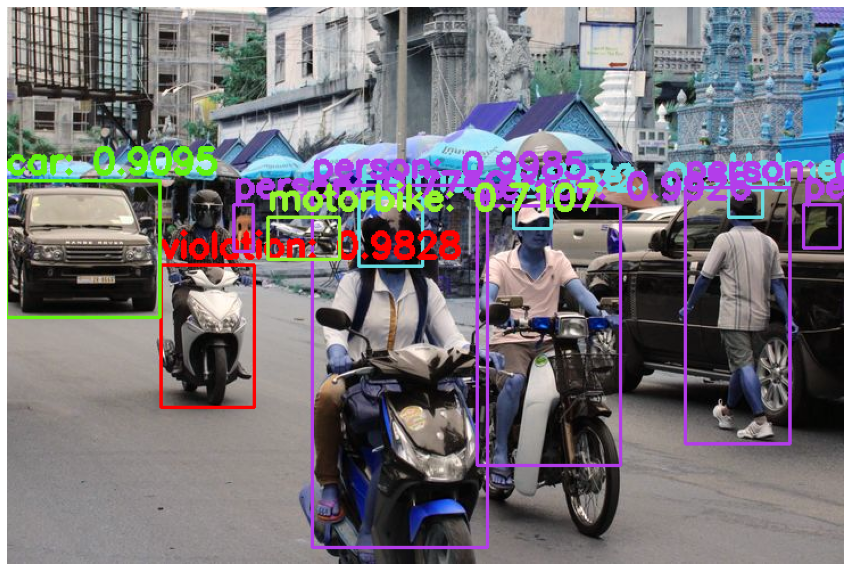

In [24]:
import urllib.request

urllib.request.urlretrieve("https://i.pinimg.com/736x/27/38/a8/2738a8dd948f3871a545f37b16f6adcc--phnom-penh-cambodia.jpg", "local-filename.jpg")

img0 = cv2.imread("local-filename.jpg")
output_image = run_model(img0)

%matplotlib inline
plt.figure(figsize = (15,15))
plt.axis('off')
plt.imshow(output_image)